# 1. Just aerobic heterotrophs

- Assume that active biomass, inert biomass and EPS are not washed out but remain in the reactor. 
- EPS and $X_i$ are mobilized via dettachment $k_{\rm det}$
- rPOC and BAP are particulates with can deposit at rate $k_{\rm att}$
- Particulates hydrolise at rate $k_{\rm hyd}$ into dissolved carbon $S$
- Other dissolved and particulate species are still advected
- Biomass growth is logistically limited by some pore-space exclusion
- Oxygen demand is only driven by substrate utilization, active biomass decays into inert biomass and EPS

\begin{equation}
\begin{array}{rcl}
    \dfrac{dnS}{dt} &=& \frac{Q}{V}(S^0 - S) - r_hX_h + k_{\rm hyd}^\mathsf{POCr}\mathsf{POCr} + k_{\rm hyd}^\mathsf{BAP}\mathsf{BAP}\\
    \dfrac{dX_h}{dt} &=& \left(Y'_hr_h - b_h \right)X_h \\
    \dfrac{d\mathsf{EPS}}{dt} &=& k_\mathsf{EPS} r_h X_h + f_d b_hX_h - k_{\rm det}\mathsf{EPS} + k_{\rm att}\mathsf{BAP}  \\
    \dfrac{dX_i}{dt} &=& (1-f_d)b_hX_h - k_{\rm det}X_i - k_{\rm det}X_i + k_{\rm att}\mathsf{POCr}\\
    \dfrac{d\mathsf{n BAP}}{dt} &=& \frac{Q}{V}(\mathsf{BAP}^0 - \mathsf{BAP}) 
        - k_{\rm hyd}^\mathsf{BAP}\mathsf{BAP} 
        + k_{\rm det}\mathsf{EPS} - k_{\rm att}\mathsf{BAP} \\
    \dfrac{d\mathsf{n POCr}}{dt} &=& \frac{Q}{V}(\mathsf{POC_r}^0 - \mathsf{POCr}) 
        - k_{\rm hyd}^\mathsf{POCr}\mathsf{POCr} 
        + k_{\rm det}X_i - k_{\rm att}\mathsf{POCr} \\
    \dfrac{dnO_2}{dt} &=& \frac{Q}{V}(O_2^0 - O_2) - \alpha_1r_hX_h \\    
\end{array}
\end{equation}

With:
- $r_h = \hat{q}_h\frac{S}{K_S+S}\frac{O_2}{K_{O_2}+O_2}\mathcal{E}$

and:
- $Y' = Y(1 - k_\mathsf{EPS})$ 

and:
- $\alpha_1 = 1 - 1.42Y'_h - k_\mathsf{EPS}$

and:
- $\mathcal{E} = (1 - \left(X_h + X_i + \mathsf{EPS}\right)/X_{\rm MAX})$

In [1]:
import numpy as np
import pandas as pd
import os, subprocess
from scipy.integrate import odeint
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt
from kinetics import Kinetics

In [2]:
REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

In [3]:
perm_0, n0 = 1.02E-11 , 0.358 #m2
perm_c, nc = 1.00E-14 , 0.10  #m2

rhoX = 2500.   #mgVSS/L(?)
Xmax = (n0 - nc) * rhoX #mgVSS/L

boolClog = True

def getPerm(n):
    return ((perm_0 - perm_c) * np.power((n-nc)/(n0-nc),3) * np.greater(n - nc,0)) + perm_c;

def getPerm_Linear(n):
    return ((perm_0 - perm_c) * (n-nc)/(n0-nc) * np.greater(n - nc,0)) + perm_c;

def getPerm_KozenyKarman(n):
    return ((perm_0 - perm_c) * np.power((n-nc)/(n0-nc),3) * np.power((1-n0+nc)/(1-n+nc),2) * np.greater(n - nc,0)) + perm_c;

In [4]:
print(f"{getPerm(n0) == perm_0 = }")
print(f"{getPerm(nc) == perm_c = }")

getPerm(n0) == perm_0 = True
getPerm(nc) == perm_c = True


In [5]:
rho, g, mu = 1000., 9.81, 0.001  #kg/m³, m/s², kg/m.s
head, Lenght, Area = 10., 10., 10.*10. #m,m,m²

def getFlow(n):
    if boolClog:
        perm = getPerm(n)
    else:
        perm = getPerm(n0)
    
    hydCond = perm * rho * g / mu  # m/s
    velFlow = hydCond * head / Lenght         # m/s
    flowRate = velFlow * Area             # m³/s
    Volume = Area * Lenght             # m³
    flow = flowRate/Volume            # 1/s
    #print(f"{k=}, {K=}, {U=}, {Q=}, {V=}")
    return flow*86400     # 1/d

print(f"Init Flowrate: {getFlow(n0):.3f} 1/d")

Init Flowrate: 0.865 1/d


In [6]:
## Use Y as Y' (Table 8.2 Rittmann 2ndEd)
# Heterotrophs kinetics
pXAR = Kinetics(0.49,7,0.3,0.8,0.18,10.,0.5)
alpha1  = 1.00 * (1. - 1.42*pXAR.Y - pXAR.kEPS) #gO2/gBOD

In [7]:
print(pXAR)

     Y =  0.490
     q =  7.000
     b =  0.300
    fd =  0.800
  kEPS =  0.180
Kdonor = 10.000
Kacceptor =  0.500



In [8]:
# Hydrolysis of particulates
khyd_BAP  = 0.17  #1/d
khyd_POCr = 0.017  #1/d

# Attachment/detachment kinetics
katt = 0
kdet = 0.17 #1/d

In [9]:
# Mass inputs
S0   = 50.    #mgBOD/L
BAP0 = 0.    #mgBOD/L
O20  = 9.    #mgO2/L
POCr0 = 0.   #mgCOD/L

## 14.1 Numerical solution.

In [10]:
def CSRT(vec,t):
    S,BAP,EPS,X,Xi,O2,POCr = vec
    
    totalBiomass = (X + Xi + EPS)
    n = n0 - totalBiomass/rhoX
    clogLimiter = 1.0 - totalBiomass/Xmax
    
    rH   = pXAR.q * (S/(pXAR.Kdonor+S)) * (O2/(pXAR.Kacceptor+O2)) * clogLimiter
    
    flow = getFlow(n)/n
    
    dX   = (pXAR.Y*rH - pXAR.b)*X
    dEPS = pXAR.kEPS*rH*X  + pXAR.fd*pXAR.b*X - kdet*EPS + n*katt*BAP 
    dXi  = (1.0 - pXAR.fd)*pXAR.b*X - kdet*Xi  + n*katt*POCr
    
    dS   = flow*(S0-S) - rH*X/n + khyd_POCr*POCr + khyd_BAP*BAP
    dO2  = flow*(O20-O2) - alpha1*rH*X/n
    
    dBAP  = flow*(BAP0-BAP)   + kdet*EPS/n  - (katt + khyd_BAP)*BAP
    dPOCr = flow*(POCr0-POCr) + kdet*Xi/n   - (katt + khyd_POCr)*POCr
    
    return [dS,dBAP,dEPS,dX,dXi,dO2,dPOCr]

In [11]:
time = np.linspace(0.0001,30,300)
names = ["S","BAP","EPS","Xh","Xi","O2","POCr"]
init =  [S0 , BAP0,  0.0, 0.1, 0., O20, POCr0]
tray = odeint(CSRT,init,time)

In [12]:
tray_df = pd.DataFrame({k:v for k,v,i in zip(names,tray.T,init)})
tray_df['Time'] = time
tray_df.set_index('Time',inplace=True)

In [13]:
tray_df["Q"] = getFlow(n0 - (tray_df['Xh']+tray_df['Xi']+tray_df['EPS'])/rhoX)
names.append("Q")

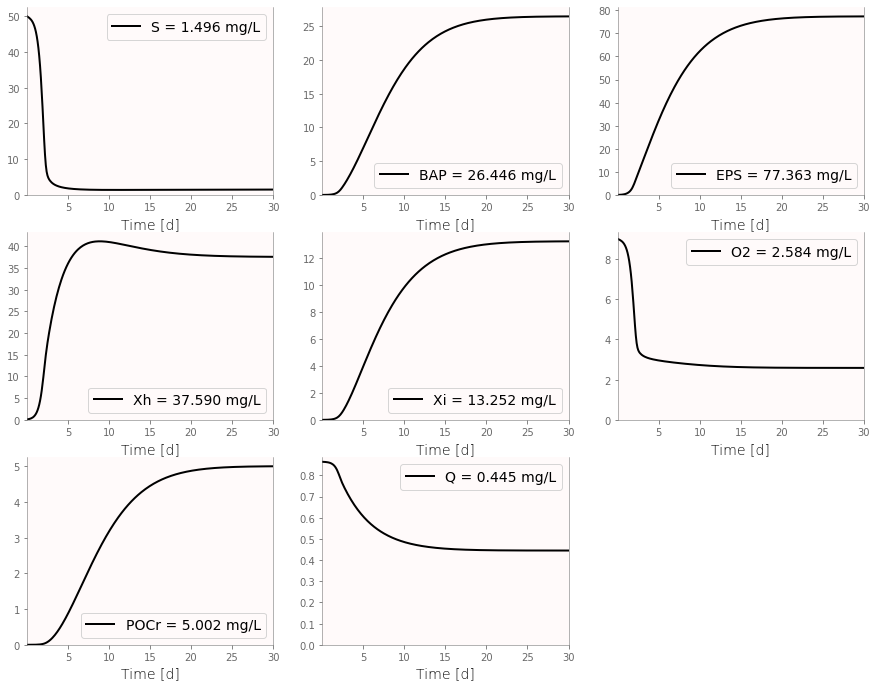

In [14]:
fig,axs = plt.subplots(5,3,figsize=[15,20])
for (name,data),ax in zip(tray_df.iteritems(),axs.flatten()):
    ax.plot(time,data,label='{0} = {1:.3f} mg/L'.format(name,data.iloc[-1]))
    ax.set(xlim=[0.01,30],xlabel="Time [d]")
    ax.set_ylim(bottom=0)
    ax.legend()
[ax.remove() for ax in axs.flatten() if not ax.has_data()]
plt.show()

### 14.2 OpenFOAM implementation 

Using `hz_bioCycle`

In [18]:
caseName   = "justAerobicRespiration"
solverFoam = "hz_bioCycle"
probeVars  = "DOC BAP EPS XAR XI O2 POCr U"

## Check that hz_bioCycle is compiled
if not(solverFoam in subprocess.run(["which",f"{solverFoam}"],capture_output=True).stdout.decode('utf-8').strip()):
    print("######### SOLVER NOT FOUND ############")

In [19]:
## Run case
os.system(f"cp {REPO_PATH}/misc/probes.tpl {caseName}/system/probes; sed -i 's/<<LIST_OF_VARIABLES_TO_MEASURE>>/({probeVars})/g' {caseName}/system/probes")
os.system(f"cd {caseName}; ./runAll.sh {solverFoam}");

In [20]:
path_case = f"{REPO_PATH}/tests/{solverFoam}/{caseName}/postProcessing/probes/0.000"
probes = os.listdir(path_case)
probes.sort()

In [21]:
results = pd.DataFrame()
for i,probe in enumerate(probes):
    if i == 0:
        results = pd.read_fwf(os.path.join(path_case,probe),
                              widths=[13,14],skiprows=3,
                              names=["Time (s)",str(probe)])
        results.set_index("Time (s)",inplace=True)
    else:
        if probe == "U":
            results = results.join(pd.read_fwf(os.path.join(path_case,probe),
                                               widths=[13,33],skiprows=3,
                                               names=["Time (s)",str(probe)]).set_index("Time (s)"),
                                   on='Time (s)')
            results['U'] = [float(v.split(" ")[-1].replace(")","")) for v in results['U']]
            results['U'] = results['U']*10*10*-86400/(1000*1000)
        
        else:
            results = results.join(pd.read_fwf(os.path.join(path_case,probe),
                                               widths=[13,14],skiprows=3,
                                               names=["Time (s)",str(probe)]).set_index("Time (s)"),
                                   on='Time (s)')

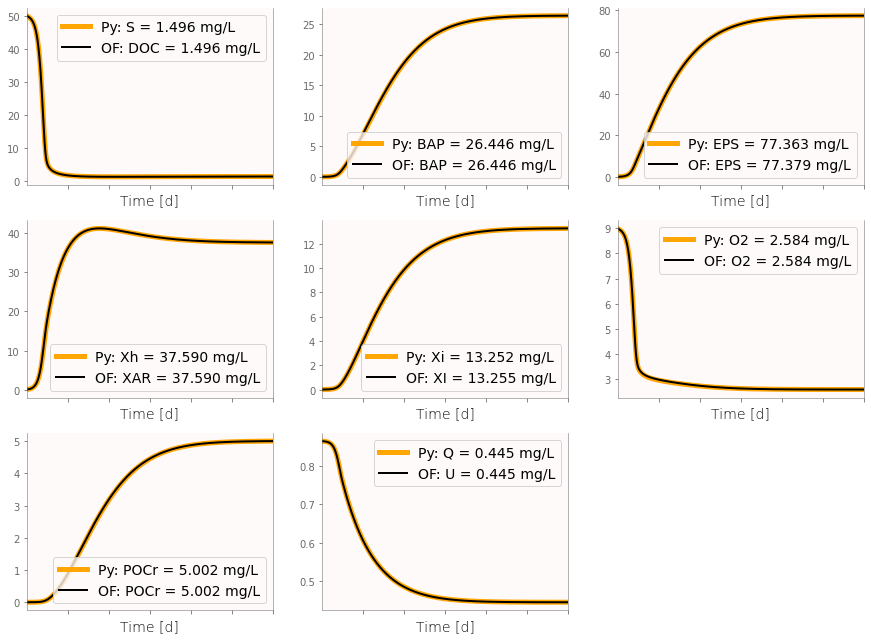

In [22]:
fig,axs = plt.subplots(4,3,figsize=[15,15],sharex=True)
texts = ['DOC', 'BAP', 'EPS', 'XAR', 'XI', 'O2', 'POCr', 'U', ]
for (name,data),ax,k in zip(tray_df.iteritems(),axs.flatten(),texts):
    ax.plot(time,data,label='Py: {0} = {1:.3f} mg/L'.format(name,data.iloc[-1]),lw=5,alpha=0.99,c='orange')
    ax.plot(results.index/86400.,results[k]*1000.,label='OF: {0} = {1:.3f} mg/L'.format(k,results[k].iloc[-1]*1000.))
    ax.set(xlim=[0.01,30],xlabel="Time [d]")
    #ax.set_ylim(bottom=0)
    ax.legend()
[ax.remove() for ax in axs.flatten() if not ax.has_data()]
plt.show()

In [23]:
# Clean timesteps
os.system(f"cd {caseName}; foamListTimes -rm; rm -r dynamicCode VTK log")

Using #calcEntry at line 19 in file "/home/edsaa/Repositories/ReactiveBiomass/tests/hz_bioCycle/justAerobicRespiration/system/controlDict"
Using #codeStream with "/home/edsaa/Repositories/ReactiveBiomass/tests/hz_bioCycle/justAerobicRespiration/dynamicCode/platforms/linux64GccDPInt32Opt/lib/libcodeStream_d3a5b5928140f374f040f246529828b8bb27144c.so"
Using #calcEntry at line 22 in file "/home/edsaa/Repositories/ReactiveBiomass/tests/hz_bioCycle/justAerobicRespiration/system/controlDict"
Using #codeStream with "/home/edsaa/Repositories/ReactiveBiomass/tests/hz_bioCycle/justAerobicRespiration/dynamicCode/platforms/linux64GccDPInt32Opt/lib/libcodeStream_ee7bc0671c86916c7dcdbbd6b4c1cf67b41367b3.so"


0